In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

# Import relevant custom libraries
from src.eda import data_info
from src.evaluation import ValidationEvaluation

# Import relevant libraries
import pandas as pd
import warnings
from IPython.display import display
import matplotlib.pyplot as plt
import math
import os
import glob

# Config
pd.set_option('display.max_columns', None) # Ensure all columns are displayed
warnings.filterwarnings("ignore")

In [2]:
# Read relevant files
X_train = pd.read_feather("../data/processed/X_train.feather")
X_train_validate = pd.read_feather("../data/processed/X_train_validate.feather")

# Get data info
var_info = data_info(X_train)
all_cols = X_train.columns
real_cols = var_info[var_info["var_type"]=="numerical"]["var_name"].tolist()
binary_cols = var_info[var_info["var_type"]=="binary"]["var_name"].tolist()

## 1. Test the trainer

In [3]:
#Failed to train model with config {'hidden_dims': (64, 32), 'batch_size': 101, 'dropout_rate': 0.27635394201074476, 'learning_rate': 0.007191783951237578, 'lam': 0.04916278144991648, 'gamma': 0.7794677063882551, 'l2norm_pct': 83, 'max_epochs': 469}: object of type 'NoneType' has no len()

"""ae = AutoencoderTrainer(
    input_dim=X_train.shape[1],
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    hidden_dims=(64, 32),
    learning_rate=0.007191783951237578,
    dropout_rate=0.27635394201074476,
    lam=0.04916278144991648,
    gamma=0.7794677063882551,
    verbose=True,
    max_epochs=469,
    plot_losses=True,
    dp_sgd=True,
    target_epsilon=0.5,
    delta=1e-5,
    batch_size=101,
    l2norm_pct=83,
    patience_limit=20,
)
autoencoder = ae.train(X_train, X_train_validate)"""

'ae = AutoencoderTrainer(\n    input_dim=X_train.shape[1],\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    hidden_dims=(64, 32),\n    learning_rate=0.007191783951237578,\n    dropout_rate=0.27635394201074476,\n    lam=0.04916278144991648,\n    gamma=0.7794677063882551,\n    verbose=True,\n    max_epochs=469,\n    plot_losses=True,\n    dp_sgd=True,\n    target_epsilon=0.5,\n    delta=1e-5,\n    batch_size=101,\n    l2norm_pct=83,\n    patience_limit=20,\n)\nautoencoder = ae.train(X_train, X_train_validate)'

## 2. Test the anomaly detector

In [4]:
"""# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# After training
detector = AnomalyDetector(
    model=autoencoder,
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    lam=ae.lam,
)

# Compute scores
scores = detector._compute_anomaly_scores(X_validate)

# Detect
threshold = np.quantile(scores, 0.8)
y_pred = detector._detect(scores, threshold)

# Evaluate
metrics = detector._evaluate(y_pred, y_validate, scores)
print(metrics)"""

'# Read relevant files\nX_validate = pd.read_feather("../data/processed/X_validate.feather")\ny_validate = pd.read_feather("../data/processed/y_validate.feather")\n\n# After training\ndetector = AnomalyDetector(\n    model=autoencoder,\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    lam=ae.lam,\n)\n\n# Compute scores\nscores = detector._compute_anomaly_scores(X_validate)\n\n# Detect\nthreshold = np.quantile(scores, 0.8)\ny_pred = detector._detect(scores, threshold)\n\n# Evaluate\nmetrics = detector._evaluate(y_pred, y_validate, scores)\nprint(metrics)'

## 3. Hyperparameter Tuning

### 3.1. Tuning Implementation

In [5]:
# Epsilon = 1
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=50 --epsilon 1 --delta 1e-5
# Epsilon = 3
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=30 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=50 --epsilon 3 --delta 1e-5
# Epsilon = 5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=30 --epsilon 5 --delta 1e-5

### 3.2. Summarize the Performance on Validation Set

In [6]:
# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# Initialize the validation evaluation
valeval = ValidationEvaluation(X_validate, y_validate, real_cols, binary_cols, all_cols, dp_sgd=True)
    
# Read the log file
log_path = "../logs/dpsgd_tune_log.txt"

# Extract the latest successful Bayesian versions
latest_successful_versions = valeval.extract_latest_successful_bayesian_versions(log_path)
print(latest_successful_versions)

# Evaluate the model performance
eval_results = valeval.evaluate_model_performance(latest_successful_versions)
eval_results = eval_results[eval_results["epsilon"]>=1]

{'202505161637': ('AUC', 1.0, 1e-05, datetime.datetime(2025, 5, 16, 18, 54, 18, 622859)), '202505070419': ('Precision', 1.0, 1e-05, datetime.datetime(2025, 5, 15, 20, 15, 45, 649085)), '202505170232': ('F1-Score', 1.0, 1e-05, datetime.datetime(2025, 5, 17, 5, 26, 3, 436569)), '202505150536': ('Recall', 1.0, 1e-05, datetime.datetime(2025, 5, 15, 18, 58, 53, 6028)), '202505161903': ('AUC', 3.0, 1e-05, datetime.datetime(2025, 5, 17, 1, 21, 4, 994784)), '202505150430': ('F1-Score', 3.0, 1e-05, datetime.datetime(2025, 5, 16, 1, 16, 29, 743064)), '202505150921': ('Precision', 3.0, 1e-05, datetime.datetime(2025, 5, 15, 20, 44, 23, 491416)), '202505150606': ('Recall', 3.0, 1e-05, datetime.datetime(2025, 5, 16, 0, 37, 31, 384408)), '202505150349': ('AUC', 5.0, 1e-05, datetime.datetime(2025, 5, 16, 1, 29, 3, 290500)), '202505150505': ('F1-Score', 5.0, 1e-05, datetime.datetime(2025, 5, 16, 0, 0, 53, 948425)), '202505151015': ('Precision', 5.0, 1e-05, datetime.datetime(2025, 5, 15, 21, 3, 33, 6546

In [7]:
display(eval_results.sort_values(by=["tuned_by", "epsilon"], ascending=True))#[['epsilon', 'tuned_by']])

,precision,recall,f1_score,auc,accuracy,hidden_dims,batch_size,dropout_rate,learning_rate,lam,gamma,l2norm_pct,max_epochs,threshold,tuned_by,delta,epsilon,end_time
version,,,,,,,,,,,,,,,,,,
202505070419,0.757417,0.188286,0.301598,0.671443,0.824561,"[64, 32]",64.0,0.245813,0.000085,0.024502,0.791777,95.0,299.0,8.721860,Precision,0.00001,1.0,2025-05-15 20:15:45.649085
202505150921,0.776614,0.193059,0.309243,0.679502,0.826482,"(64, 32)",116.0,0.376350,0.000725,0.000100,0.823510,95.0,360.0,5.372375,Precision,0.00001,3.0,2025-05-15 20:44:23.491416
202505151015,0.781850,0.194360,0.311327,0.681884,0.827005,"(64, 32)",93.0,0.261762,0.000920,0.000327,0.826100,83.0,241.0,5.055078,Precision,0.00001,5.0,2025-05-15 21:03:33.654616
202505150536,0.382892,0.570933,0.458377,0.728678,0.728550,"(64, 32)",90.0,0.295517,0.000039,0.018745,0.999000,92.0,310.0,2.303861,Recall,0.00001,1.0,2025-05-15 18:58:53.006028
202505150606,0.415770,0.619957,0.497736,0.752863,0.748276,"[64, 32]",147.0,0.362238,0.000445,0.000100,0.977776,75.0,518.0,1.016148,Recall,0.00001,3.0,2025-05-16 00:37:31.384408
202505150652,0.421880,0.629067,0.505051,0.749435,0.751942,"[64, 32]",91.0,0.000000,0.000094,0.000100,0.999000,95.0,164.0,0.234706,Recall,0.00001,5.0,2025-05-16 00:33:50.439339
202505170232,0.412716,0.487202,0.446876,0.704946,0.757354,"(64,)",78.0,0.328455,0.000008,0.005630,0.999000,78.0,385.0,0.927449,F1-Score,0.00001,1.0,2025-05-17 05:26:03.436569
202505150430,0.468578,0.553145,0.507362,0.757268,0.783888,"[64, 32]",100.0,0.380729,0.000656,0.000100,0.999000,84.0,271.0,0.312887,F1-Score,0.00001,3.0,2025-05-16 01:16:29.743064
202505150505,0.556608,0.484165,0.517865,0.747434,0.818626,"(64,)",67.0,0.000000,0.000704,0.000100,0.999000,83.0,567.0,0.078372,F1-Score,0.00001,5.0,2025-05-16 00:00:53.948425


In [8]:
eval_results.to_csv("../experiments/perf_summary/dpsgd_val_results.csv")

### 3.3. Compare Models Based on Validation Set

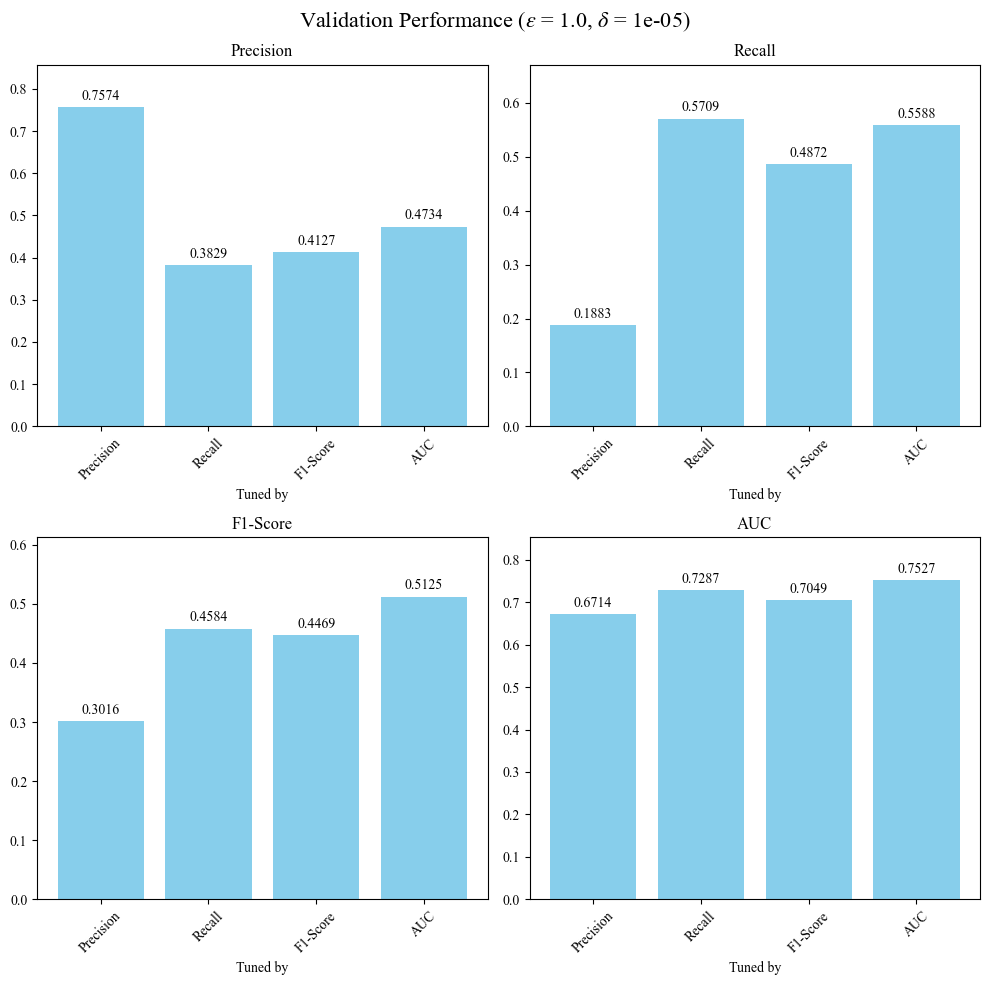

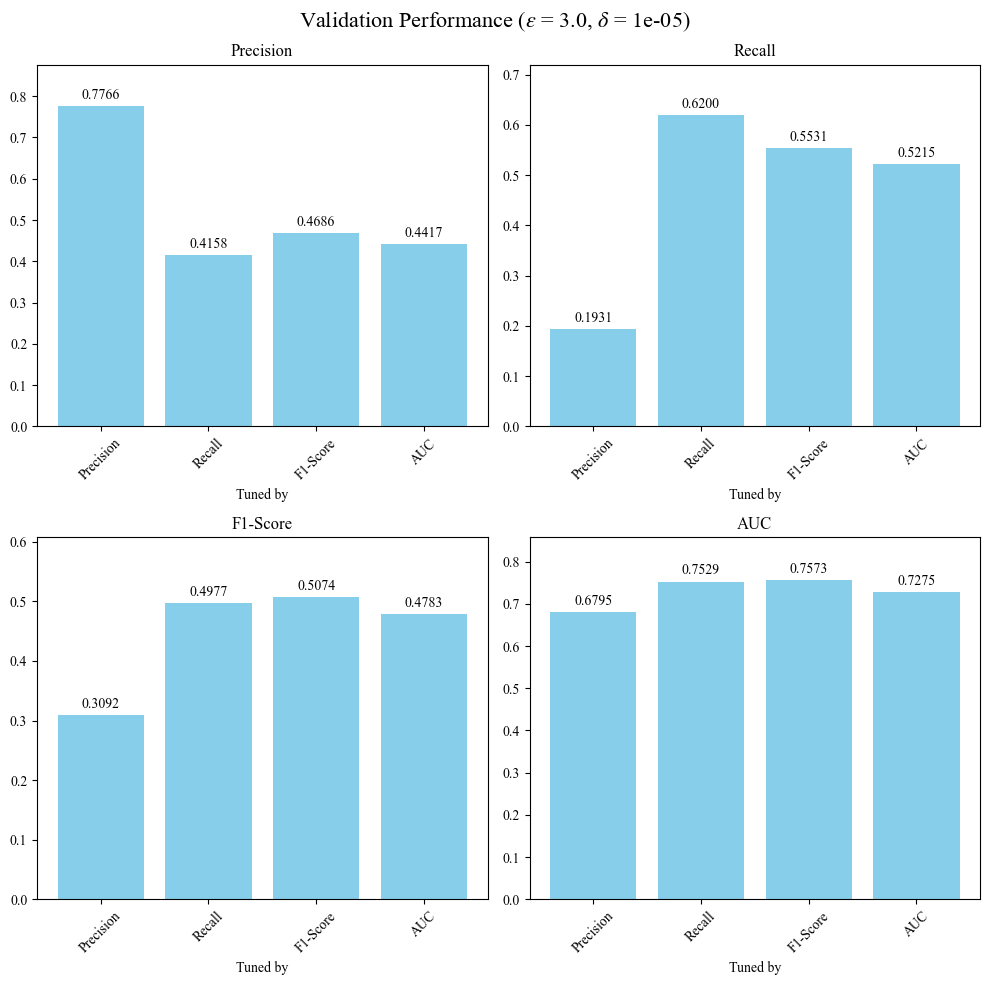

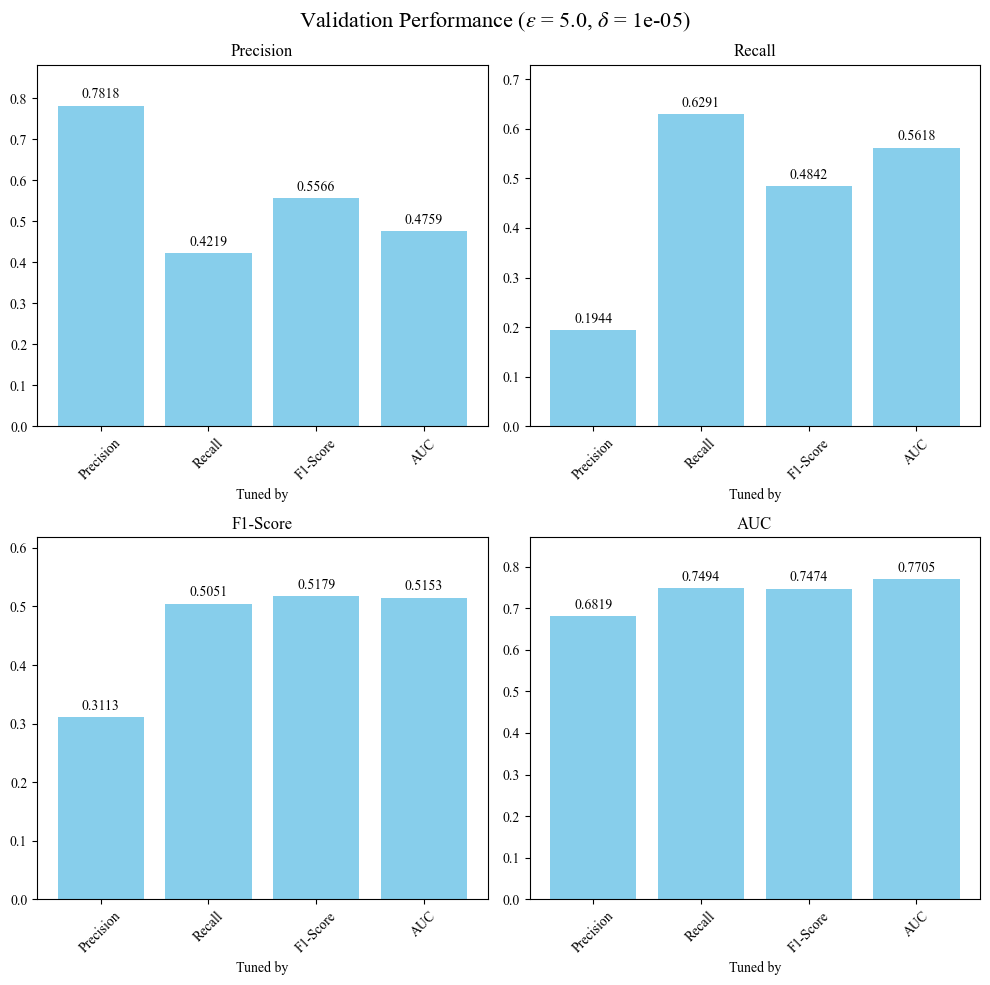

In [9]:
##################################################
## Plot a barplot of the validation performance ##
##################################################

valeval.plot_bar(eval_results, save=False)

### 3.4. Inspect Convergence of Bayesian Optimization

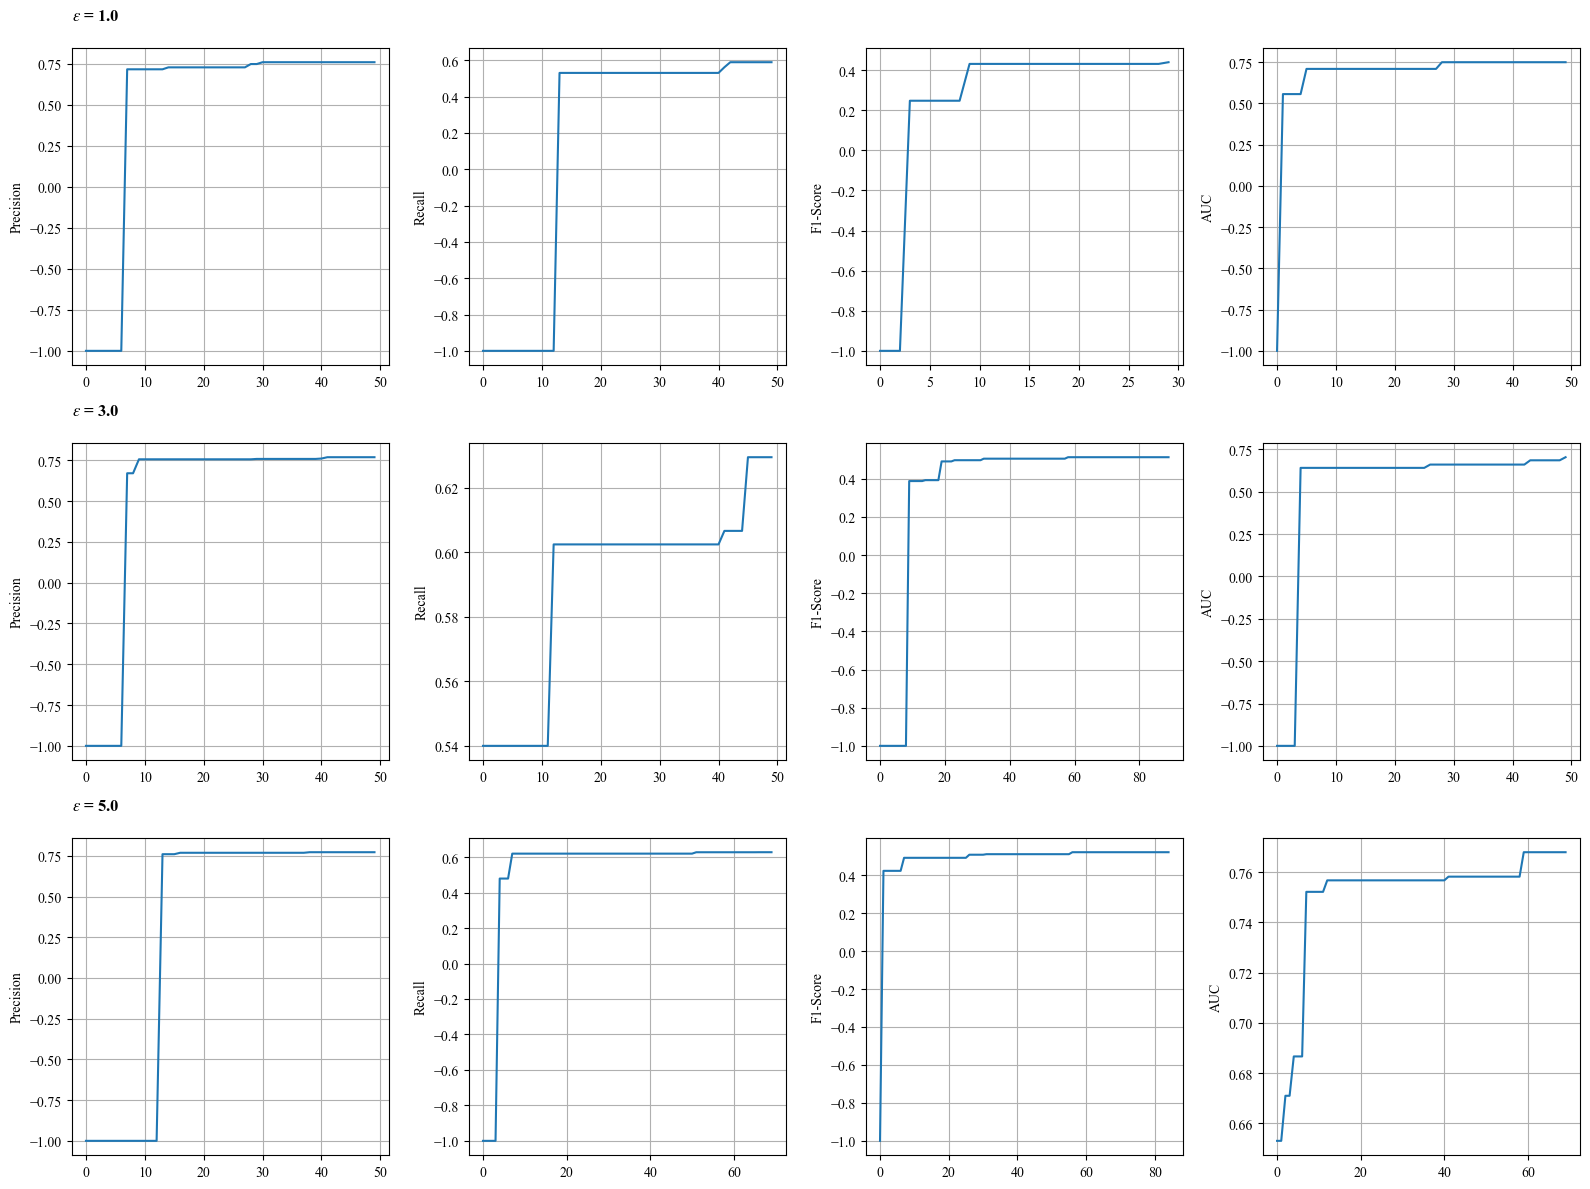

In [10]:
# Sort and reset index for consistent iteration
sorted_results = eval_results.sort_values(by=["epsilon"], ascending=True).reset_index()

# Set up grid
n_cols = 4
n_rows = math.ceil(len(sorted_results) / n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

# Track previous epsilon for row titles
row_epsilons = []

for i, row in sorted_results.iterrows():
    ax = axes[i]
    metric = row["tuned_by"].lower().replace("-", "_")
    version = row["version"]
    epsilon = row["epsilon"]

    # Read result file
    results_df = pd.read_csv(f"../experiments/hyperparam_tune/dpsgd/bayes_{metric}_{version}.csv")
    results_df["best_so_far"] = results_df[metric].cummax()

    # Plot
    ax.plot(results_df.index, results_df["best_so_far"])
    ax.set_ylabel(row["tuned_by"])
    ax.grid(True)

    # If it's the first column in a row, set a title for that row
    if i % n_cols == 0:
        ax.set_title(f"$\\varepsilon$ = {epsilon}", loc='left', fontsize=12, fontweight='bold', pad=20)

# Hide unused subplots if total is not a multiple of n_cols
for j in range(len(sorted_results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 3.5. Check Convergence of the Final Training

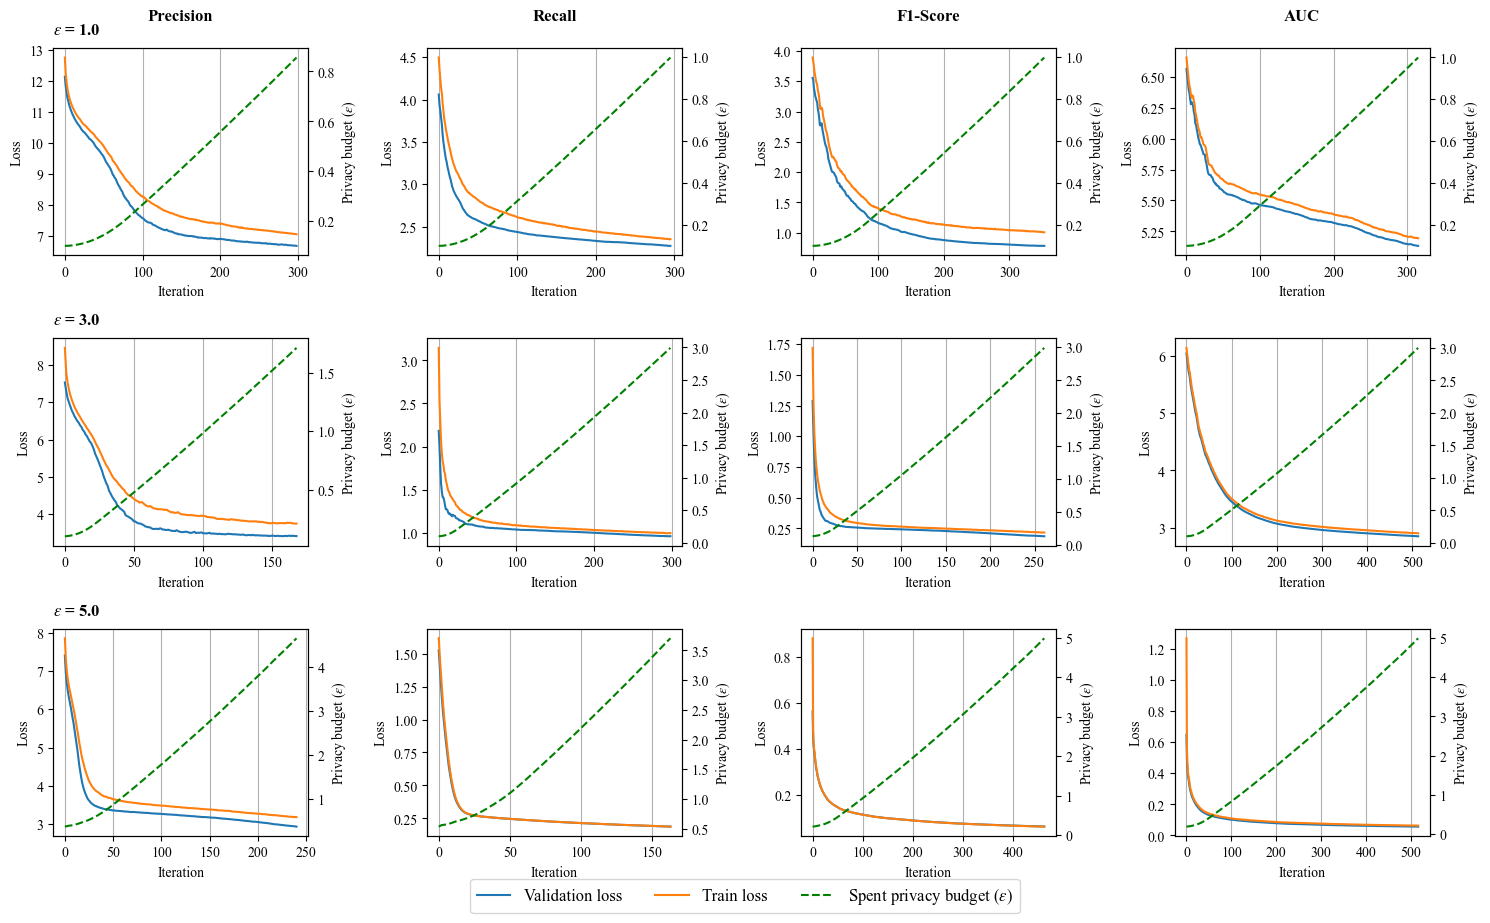

In [11]:
# Sort and reset index for consistent iteration
sorted_results = eval_results.sort_values(by=["epsilon"], ascending=True).reset_index()

# Set up grid
n_cols = 4
n_rows = math.ceil(len(sorted_results) / n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

# Track previous epsilon for row titles
row_epsilons = []

for i, row in sorted_results.iterrows():
    ax1 = axes[i]
    # Create second y-axis sharing the same x-axis
    ax2 = ax1.twinx()
    version = row["version"]
    epsilon = row["epsilon"]
    metric = row["tuned_by"]

    # Read result file
    folder = "../experiments/tracking"

    # Read the existing files with the same version prefix
    pattern = os.path.join(folder, f"{version}_noise*.csv")
    for file in glob.glob(pattern):
        results_df = pd.read_csv(file)

    # Plot loss on the left y-axis
    val = ax1.plot(results_df.index, results_df["val_loss"], label='Validation loss')
    train = ax1.plot(results_df.index, results_df["train_loss"], label='Train loss')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='y')

    # Plot epsilon on the right y-axis
    priv = ax2.plot(results_df.index, results_df["spent_eps"], label=r'Spent privacy budget ($\varepsilon$)', color='g', linestyle='--')
    ax2.set_ylabel(r'Privacy budget ($\varepsilon$)')
    ax2.tick_params(axis='y')

    # added these three lines
    lns = val + train + priv
    labs = [l.get_label() for l in lns]
    
    # Set grid for x-axis
    ax1.grid(True, axis='x')

    # Set a title specific to each subplot
    if i // n_cols == 0:
        ax2.set_title(f"{metric}", fontsize=12, pad=20, fontweight='bold')

    # If it's the first column in a row, set a title for that row
    if i % n_cols == 0:
        ax1.set_title(f"$\\varepsilon$ = {epsilon}", loc='left', fontsize=12, fontweight='bold', pad=10)

# Hide unused subplots if total is not a multiple of n_cols
for j in range(len(sorted_results), len(axes)):
    fig.delaxes(axes[j])

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(lns, labs, loc='lower center', bbox_to_anchor=(0.5, -0.03),
           ncol=3, fontsize=12)

plt.tight_layout()
plt.show()

In [12]:
# Filter and pivot to prepare LaTeX table data
selected_metrics = ["precision", "recall", "f1_score", "auc"]
df_filtered = eval_results[eval_results["tuned_by"].isin(["Precision", "Recall", "F1-Score", "AUC"])]
df_filtered = df_filtered[df_filtered["epsilon"].isin([1.0, 3.0, 5.0])]
df_filtered["tuned_by"] = df_filtered["tuned_by"].str.replace("F1-Score", "F1-score")

# Group and find best metrics for each (epsilon, tuned_by)
def format_row(row, max_vals):
    return " & ".join([
        f"\\textbf{{{row[m]*100:.2f}}}" if row[m] == max_vals[m] else f"{row[m]*100:.2f}"
        for m in selected_metrics
    ])

latex_rows = []
for eps in sorted(df_filtered["epsilon"].unique()):
    group = df_filtered[df_filtered["epsilon"] == eps]
    latex_rows.append(f"\\multirow[t]{{4}}{{*}}{{{eps}}}")
    for obj in ["Precision", "Recall", "F1-score", "AUC"]:
        row = group[group["tuned_by"] == obj]
        if row.empty:
            latex_rows.append(f"& {obj} & -- & -- & -- & -- \\\\")
        else:
            row = row.iloc[0]
            max_vals = group[selected_metrics].max()
            metrics_str = format_row(row, max_vals)
            latex_rows.append(f"& {obj} & {metrics_str} \\\\")
    latex_rows.append("\\midrule")

# Compose the full LaTeX table
latex_table = r"""
\begin{table}[!t]
    \centering
    \caption{Validation performance (\%) of DP-SGD models under different tuning objectives and privacy levels ($\delta = 10^{-5}$)}
    \label{tab:dpsgd-validation}
    \begin{tabular}{clcccc}
    \toprule
    $\boldsymbol{\varepsilon}$ & \textbf{Tuning Objective} & \textbf{Precision} & \textbf{Recall} & \textbf{F1-score} & \textbf{AUC} \\
    \midrule
""" + "\n".join(latex_rows) + r"""
    \bottomrule
    \end{tabular}
    \vspace{2mm}
    \caption*{\footnotesize Validation performance of DP-SGD models is reported as percentages under four tuning objectives (Precision, Recall, F1-score, and AUC) and four privacy budgets ($\varepsilon \in \{0.5, 1, 3, 5\}$), with fixed $\delta = 10^{-5}$. The rows indicate the objective used during tuning; the columns report the resulting performance on each metric. All values are in percentage points. The highest value for each $\varepsilon$-specific group is highlighted in bold. Final hyperparameter configurations are provided in Appendix~\ref{a:hyper_select}.}
\end{table}
"""

print(latex_table)


\begin{table}[!t]
    \centering
    \caption{Validation performance (\%) of DP-SGD models under different tuning objectives and privacy levels ($\delta = 10^{-5}$)}
    \label{tab:dpsgd-validation}
    \begin{tabular}{clcccc}
    \toprule
    $\boldsymbol{\varepsilon}$ & \textbf{Tuning Objective} & \textbf{Precision} & \textbf{Recall} & \textbf{F1-score} & \textbf{AUC} \\
    \midrule
\multirow[t]{4}{*}{1.0}
& Precision & \textbf{75.74} & 18.83 & 30.16 & 67.14 \\
& Recall & 38.29 & \textbf{57.09} & 45.84 & 72.87 \\
& F1-score & 41.27 & 48.72 & 44.69 & 70.49 \\
& AUC & 47.34 & 55.88 & \textbf{51.25} & \textbf{75.27} \\
\midrule
\multirow[t]{4}{*}{3.0}
& Precision & \textbf{77.66} & 19.31 & 30.92 & 67.95 \\
& Recall & 41.58 & \textbf{62.00} & 49.77 & 75.29 \\
& F1-score & 46.86 & 55.31 & \textbf{50.74} & \textbf{75.73} \\
& AUC & 44.17 & 52.15 & 47.83 & 72.75 \\
\midrule
\multirow[t]{4}{*}{5.0}
& Precision & \textbf{78.18} & 19.44 & 31.13 & 68.19 \\
& Recall & 42.19 & \textbf{62.91} & 